In [322]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from BoredQiskit import FastQiskit as fq
from BoredQiskit import FastUtilsGate as fg
from BoredQiskit.FastUtilsGate import int_to_bin
import numpy as np

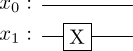

In [323]:
def encode_boolean_string(x: str):
    n = len(x)
    qx = QuantumRegister(n, 'x')
    qc = QuantumCircuit(qx)

    for c, i in enumerate(x):
        if i == '1':
            qc.x(qx[n - c - 1])
    
    return qc

encode_boolean_string('10').draw('latex')

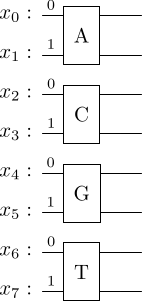

In [324]:
# A=00, C=01, G=10, T=11

def encode_dna_string(x: str):

    mapping = {
        'A': '00',
        'C': '01',
        'G': '10',
        'T': '11' 
    }

    n = len(x)
    qx = QuantumRegister(n*2, 'x')
    qc = QuantumCircuit(qx)

    for c, i in enumerate(x):
        bits = mapping[i]
        qg = QuantumCircuit(2)
        for b, j in enumerate(bits):
            if j == '1':
                qg.x(b)

        qg = qg.to_gate(label=i) 
        qc = qc.compose(qg, [c*2,c*2+1])

    return qc

encode_dna_string('ACGT').draw('latex')

In [325]:
def quantum_rotation(n: int, s: int):
    '''
    Returns a `.Gate` that implements a rotation
    of `s` positions on `n` qubits lines.
    
    Only works correctly if `s` is a power of 2. Every other
    rotation can be obtained by combination of the power of 2 rotations; so

    DONT USE THIS !!!
    '''
    qr = QuantumRegister(n, 'q')
    qc = QuantumCircuit(qr)
    
    for i in range(1, int(np.ceil(n/2))):
        qc.swap(qr[i], qr[n-i])
    
    for j in range(1, int(np.ceil(n/2))):
        qc.swap(qr[int(np.ceil(s/2))-j], qr[int(np.floor(s/2))+j])

    return qc.to_gate(label='R_'+str(s)+' ')


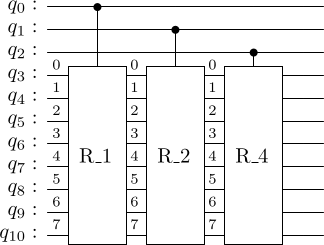

In [326]:
def quantum_controlled_rotation(n: int):
    '''
    Returns an arbitrary rotation `.Gate` on `n` qubits lines.

    page 9 of the paper
    '''
    l = np.log2(n)
    l = int(np.ceil(l))

    jr = QuantumRegister(l, 'j')
    qr = QuantumRegister(n, 'q')

    qc = QuantumCircuit(jr, qr)
    for i in range(l):
        
        qc = qc.compose(quantum_rotation(n, 2**i).control(1), [i,*qr])
    return qc.to_gate(label='ROT')

qc = QuantumCircuit(11)
qc = qc.compose(quantum_controlled_rotation(8)).decompose()
qc.draw('latex')


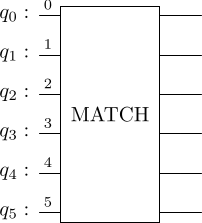

In [327]:
def match_operator(n: int):
    '''
    page 12 of the paper
    '''
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    qout = QuantumRegister(n, 'o')
    qc = QuantumCircuit(qx, qy, qout)
    
    for i in range(n):
        qc.ccx(qx[i], qy[i], qout[i])

    qc.x(qx)
    qc.x(qy)

    for i in range(n):
        qc.ccx(qx[i], qy[i], qout[i])
    
    qc.x(qx)
    qc.x(qy)
    
    return qc.to_gate(label='MATCH')

qc = QuantumCircuit(6)
qc = qc.compose(match_operator(2))#.decompose()
qc.draw('latex')

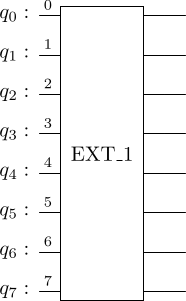

In [328]:
def extension_operator(n: int, i: int):
    '''
    page 12 of the paper
    '''
    qin = QuantumRegister(n, 'in')
    qout = QuantumRegister(n, 'out')
    qc = QuantumCircuit(qin, qout)
    
    for j in range(n):
        if j + i >= n:
            break
        qc.ccx(qin[j], qin[j+i], qout[j])

    return qc.to_gate(label='EXT_'+str(i))


qc = QuantumCircuit(8)
qc = qc.compose(extension_operator(4,1))#.decompose()
qc.draw('latex')

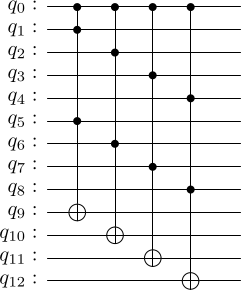

In [329]:
def contr_bitwise_and_operator(n: int):
    '''
    page 13 of the paper
    '''
    qx = QuantumRegister(1, 'c')
    qa = QuantumRegister(n, 'a')
    qb = QuantumRegister(n, 'b')
    qout = QuantumRegister(n, 'out')
    qc = QuantumCircuit(qx, qa, qb, qout)
    
    for i in range(n):
        qc.mcx([qx, qa[i], qb[i]], qout[i])

    return qc.to_gate(label='C-AND')


qc = QuantumCircuit(13)
qc = qc.compose(contr_bitwise_and_operator(4)).decompose()
qc.draw('latex')

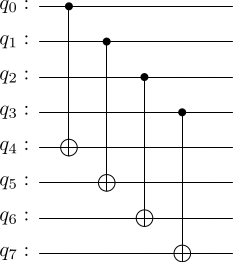

In [330]:
def copy_operator(n: int):
    '''
    page 13 of the paper
    '''
    qin = QuantumRegister(n, 'in')
    qout = QuantumRegister(n, 'out')
    qc = QuantumCircuit(qin, qout)

    for i in range(n):
        qc.cx(qin[i], qout[i])
    
    
    return qc.to_gate(label='C-COPY')


qc = QuantumCircuit(8)
qc = qc.compose(copy_operator(4)).decompose()
qc.draw('latex')

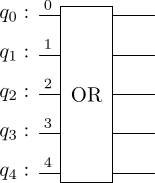

In [331]:
def or_operator(n: int):
    '''
    page 15 of the paper
    '''
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(1, 'y')
    qc = QuantumCircuit(qx, qy)
    
    qc.x(qx)
    qc.mcx(qx, qy)
    qc.x(qx)
    qc.x(qy)

    return qc.to_gate(label='OR')

qc = QuantumCircuit(5)
qc = qc.compose(or_operator(4))#.decompose()
qc.draw('latex')

In [332]:
def quantum_LCS_test():
    return False

In [333]:
X = '10111010110'
Y = '00100111010'

def quantum_LCS(x: str, y: str, n):
    l = 0
    r = n

    while l < r:
        d = np.floor((l + r) / 2)
        if quantum_LCS_test(): ## QUANTUM TEST
            l = d
        else:
            r = d - 1

    return l

print(quantum_LCS(X, Y, len(X)))

0


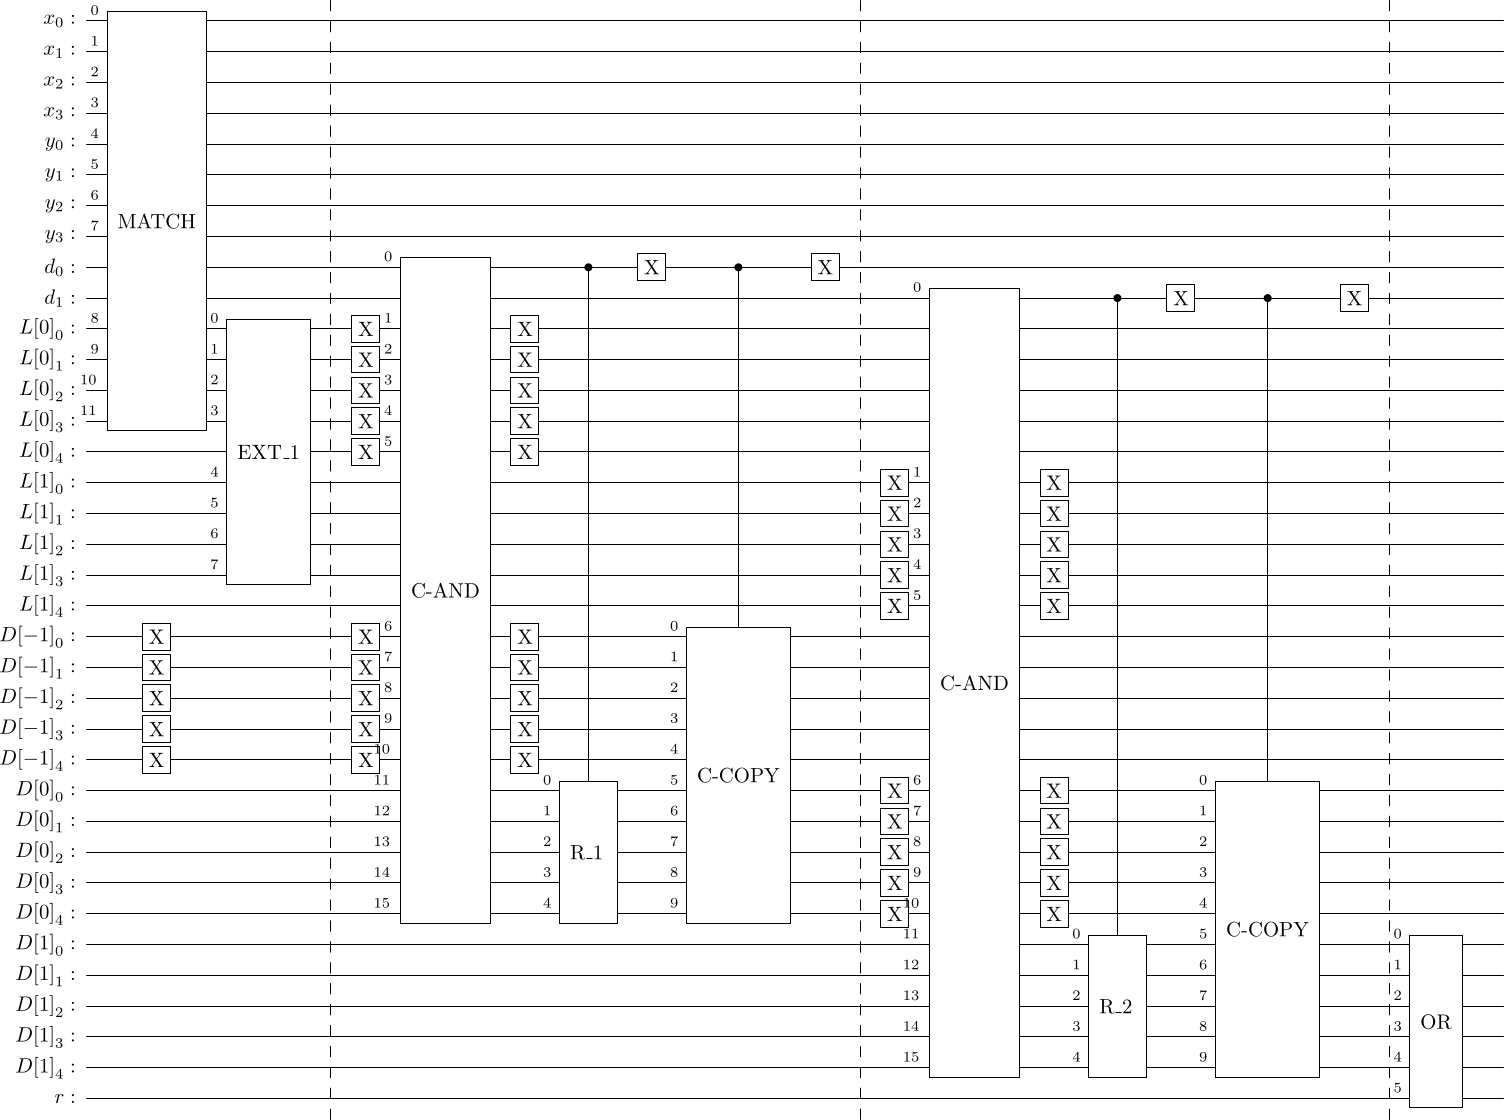

In [344]:
def FSM(n):
    '''
    builds the Fixed Substring Matching operator for inputs of size `n`

    QUBITS NEEDED:
    - `n` qubits for string x
    - `n` qubits for string y
    - `log_2(n)` qubits for string d
    - ancilla qubits
    - 1 result qubit
    '''
    d_len = int(np.ceil(np.log2(n)))
    L_num = d_len
    qx = QuantumRegister(n, 'x')
    qy = QuantumRegister(n, 'y')
    qd = QuantumRegister(d_len, 'd')
    qD = QuantumRegister(d_len+1, 'D')
    qL = []

    for i in range(L_num): # padding
        qL.append(QuantumRegister(n+1, 'L['+str(i)+']'))
    
    qD = []
    for i in range(d_len+1):
        qD.append(QuantumRegister(n+1, 'D['+str(i-1)+']'))
    
    qr = QuantumRegister(1, 'r')
    qc = QuantumCircuit(qx,qy,qd,*qL,*qD,qr)
    
    qc = qc.compose(match_operator(n), [*qx, *qy, *qL[0][:n]])

    for i in range(L_num-1):
        qc = qc.compose(extension_operator(n, i+1), [*qL[i][:n], *qL[i+1][:n]])

    qc.x(qD[0])

    qc.barrier()

    
    for i in range(d_len):
        qc.x(qL[i])
        qc.x(qD[i])
        qc = qc.compose(contr_bitwise_and_operator(n+1), [qd[i], *qL[i], *qD[i], *qD[i+1]])
        qc.x(qL[i])
        qc.x(qD[i])
        controlled_rot = quantum_rotation(n+1, 2**i).control(1)
        qc = qc.compose(controlled_rot, [qd[i], *qD[i+1]])
        qc.x(qd[i])
        controlled_copy = copy_operator(n+1).control(1)
        qc = qc.compose(controlled_copy, [qd[i],*qD[i], *qD[i+1]])
        qc.x(qd[i])
        
        qc.barrier()

    qc = qc.compose(or_operator(n+1), [*qD[d_len], qr])
    return qc

FSM(4).draw('latex')
